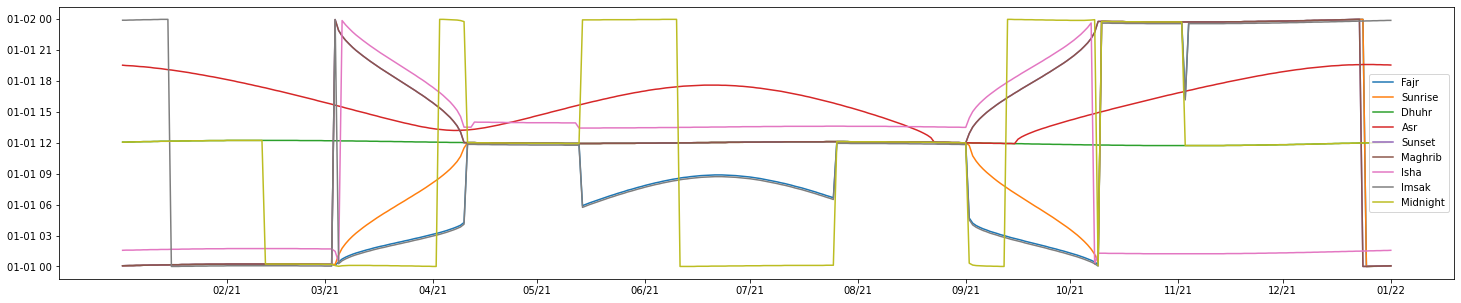

In [189]:
import requests
import json
import re
import datetime
import itertools
from functools import lru_cache
from collections import defaultdict
URL = "http://api.aladhan.com/v1/calendar"

# Location
latitude = -82.8628
longitude = 135.0000

method = 4
"""
0 - Shia Ithna-Ansari
1 - University of Islamic Sciences, Karachi
2 - Islamic Society of North America
3 - Muslim World League
4 - Umm Al-Qura University, Makkah
5 - Egyptian General Authority of Survey
7 - Institute of Geophysics, University of Tehran
8 - Gulf Region
9 - Kuwait
10 - Qatar
11 - Majlis Ugama Islam Singapura, Singapore
12 - Union Organization islamic de France
13 - Diyanet İşleri Başkanlığı, Turkey
14 - Spiritual Administration of Muslims of Russia
99 - Custom. See https://aladhan.com/calculation-methods
"""

@lru_cache(maxsize=None)
def get_times_month(month, year, latitude=latitude, longitude=longitude, method_=method):
    r = requests.get(URL, params = {
        "latitude": latitude,
        "longitude": longitude,
        "method": method,
        "month": month,
        "year": year})
    return json.loads(r.content)["data"]

def get_timestamps_day(month, year, day, latitude=latitude, longitude=longitude, method=method):
    temp = get_times_month(month, year, latitude, longitude, method)[day-1]
    out = dict()
    for name, time in temp["timings"].items():
        time = re.findall("\d\d:\d\d", time)[0]
        hour = int(time.split(":")[0])
        minute = int(time.split(":")[1])
        out[name] = datetime.datetime(year, month, day, hour, minute)
    return out

start = datetime.date(2021,1,1)
day = datetime.timedelta(days=1)

# Scrape prayer times for a year
PRAYER_TIMES = defaultdict(list)
while start.year != 2022:
    #print(start)
    start += day
    tmp = get_timestamps_day(start.month, start.year, start.day)
    for i in tmp:
        PRAYER_TIMES[i].append(tmp[i])
        
# Plot the times
import matplotlib.pyplot as plt
date = datetime.date(2000, 1, 1)
ax, fig = plt.subplots(figsize=(25,5))

for i in PRAYER_TIMES:
    times = [datetime.datetime.combine(date, j.time()) for j in PRAYER_TIMES[i]]
    y_labels = [j.time().strftime("%H:%M") for j in times]
    x_labels = [j.date().strftime("%m/%y") for j in PRAYER_TIMES[i]]
    tick_labels = [(i[0],j) for i,j in zip(list(itertools.groupby(x_labels))[1:],
                      itertools.accumulate([len(list(i[1])) for i in itertools.groupby(x_labels)]))]
    fig.plot(times, label=i)
    plt.xticks([i[1] for i in tick_labels], [i[0] for i in tick_labels])
fig.legend()